# Norman 2019 Training Demo

In this tutorial, we will train and evaluate a CPA model on the Norman 2019 dataset. 

The following steps are going to be covered:
1. Setting up environment
2. Loading the dataset
3. Preprocessing the dataset
4. Creating a CPA model
5. Training the model
6. Latent space visualization
7. Prediction evaluation across different perturbations

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools --upgrade
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa

In [2]:
import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/data/mohsen/scPert/scPerturb/Norman2019_normalized_hvg.h5ad'

## Loading dataset

The preprocessed Norman et. al 2019 dataset with `h5ad` extension used for saving/loading anndata objects is publicly available in the [Google Drive](https://drive.google.com/drive/folders/1pxT0fvXtqBBtdv1CCPVwJaMLHe9XpMHo?usp=sharing) and can be loaded using the `sc.read` function with the `backup_url` argument.

In [6]:
adata = sc.read(data_path, 
                backup_url='https://drive.google.com/u/0/uc?id=1pxT0fvXtqBBtdv1CCPVwJaMLHe9XpMHo&export=download')
adata

AnnData object with n_obs × n_vars = 111122 × 5044
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_counts', 'condition', 'pert_type', 'cell_type', 'source', 'condition_ID', 'control', 'dose_value', 'pathway', 'cov_cond', 'pert', 'split_hardest', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5', 'split_6', 'cond_harm'
    var: 'ensemble_id', 'ncounts', 'ncells', 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'gene_embedding_path', 'hvg', 'log1p', 'neighbors', 'rank_genes_groups_cov', 'source_colors', 'split_1_colors', 'split_2_colors', 'split_3_colors', 'split_4_colors', 'split_5_colors', 'split_hardest_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'd

Next, we just replace `adata.X` with raw counts to be able to train CPA with Negative Binomial (aka NB) loss.

In [7]:
adata.X = adata.layers['counts'].copy()

## Pre-processing Dataset
Preprocessing is the first step required for training a model. Just like scvi-tools models, you can call `cpa.CPA.setup_anndata` to preprocess your data. This function will accept the following arguments:
- `adata`: AnnData object containing the data to be preprocessed
- `perturbation_key`: The key in `adata.obs` that contains the perturbation information
- `control_group`: The name of the control group in `perturbation_key`
- `batch_key`: The key in `adata.obs` that contains the batch information
- `dosage_key`: The key in `adata.obs` that contains the dosage information
- `categorical_covariate_keys`: A list of keys in `adata.obs` that contain categorical covariates
- `is_count_data`: Whether the `adata.X` is count data or not
- `deg_uns_key`: The key in `adata.uns` that contains the differential expression results
- `deg_uns_cat_key`: The key in `adata.obs` that contains the category information of each cell which can be used as to access differential expression results in `adata.uns[deg_uns_key]`. For example, if `deg_uns_key` is `rank_genes_groups_cov` and `deg_uns_cat_key` is `cov_cond`, then `adata.uns[deg_uns_key][cov_cond]` will contain the differential expression results for each category in `cov_cond`.
- `max_comb_len`: The maximum number of perturbations that are applied to each cell. For example, if `max_comb_len` is 2, then the model will be trained to predict the effect of single perturbations and the effect of double perturbations.

In [10]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition_ID',
                      control_group='ctrl',
                      dosage_key='dose_value',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=2,
                     )

100%|██████████| 235/235 [00:00<00:00, 1238.45it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [11]:
model_params = {
    'n_latent': 32,
    'recon_loss': 'zinb',
    'n_hidden_encoder': 1024,
    'n_layers_encoder': 3,
    'n_hidden_decoder': 1024,
    'n_layers_decoder': 3,
    'use_batch_norm_encoder': False,
    'use_layer_norm_encoder': True,
    'use_batch_norm_decoder': False,
    'use_layer_norm_decoder': False,
    'dropout_rate_encoder': 0.1,
    'dropout_rate_decoder': 0.2,
    'variational': False,
    'seed': 659
}

trainer_params = {
    'n_epochs_adv_warmup': 10,
    'n_epochs_mixup_warmup': 5,
    'n_epochs_pretrain_ae': 5,
    'mixup_alpha': 0.0,
    'lr': 0.0001,
    'wd': 4e-07,
    'adv_steps': 5,
    'reg_adv': 40.0,
    'pen_adv': 30.0,
    'adv_lr': 0.001,
    'adv_wd': 4e-07,
    'n_layers_adv': 2,
    'n_hidden_adv': 128,
    'use_batch_norm_adv': False,
    'use_layer_norm_adv': False,
    'dropout_rate_adv': 0.3,
    'step_size_lr': 10,
    'do_clip_grad': False,
    'adv_loss': 'focal',
    'gradient_clip_value': 1.0,
    'n_epochs_verbose': 5,
}

Train/valid/test random split

In [12]:
import numpy as np
adata.obs['split'] = np.random.choice(['train', 'valid', 'test'], adata.n_obs, p=[0.8, 0.1, 0.1])

## CPA Model

You can create a CPA model by creating an object from `cpa.CPA` class. The constructor of this class takes the following arguments:
**Data related parameters:** 
- `adata`: AnnData object containing train/valid/test data
- `split_key`: The key in `adata.obs` that contains the split information
- `train_split`: The value in `split_key` that corresponds to the training data
- `valid_split`: The value in `split_key` that corresponds to the validation data
- `test_split`: The value in `split_key` that corresponds to the test data
**Model architecture parameters:**
- `n_latent`: Number of latent dimensions
- `recon_loss`: Reconstruction loss function. Currently, Supported losses are `nb`, `zinb`, and `gauss`.
- `n_hidden_encoder`: Number of hidden units in the encoder
- `n_layers_encoder`: Number of layers in the encoder
- `n_hidden_decoder`: Number of hidden units in the decoder
- `n_layers_decoder`: Number of layers in the decoder
- `use_batch_norm_encoder`: Whether to use batch normalization in the encoder
- `use_layer_norm_encoder`: Whether to use layer normalization in the encoder
- `use_batch_norm_decoder`: Whether to use batch normalization in the decoder
- `use_layer_norm_decoder`: Whether to use layer normalization in the decoder
- `dropout_rate_encoder`: Dropout rate in the encoder
- `dropout_rate_decoder`: Dropout rate in the decoder
- `variational`: Whether to use variational inference. NOTE: False is highly recommended.
- `seed`: Random seed

In [13]:
model = cpa.CPA(adata=adata, 
                split_key='split',
                train_split='train',
                valid_split='valid',
                test_split='test',
                **model_params,
               )

Global seed set to 659


## Training CPA

In order to train your CPA model, you need to use `train` function of your `model`. This function accepts the following parameters:
- `max_epochs`: Maximum number of epochs to train the model. CPA generally converges after high number of epochs, so you can set this to a high value.
- `use_gpu`: If you have a GPU, you can set this to `True` to speed up the training process.
- `batch_size`: Batch size for training. You can set this to a high value (e.g. 512, 1024, 2048) if you have a GPU. 
- `plan_kwargs`: dictionary of parameters passed the CPA's `TrainingPlan`. You can set the following parameters:
    * `n_epochs_adv_warmup`: Number of epochs to linearly increase the weight of adversarial loss. 
    * `n_epochs_mixup_warmup`: Number of epochs to linearly increase the weight of mixup loss.
    * `n_epochs_pretrain_ae`: Number of epochs to pretrain the autoencoder.
    * `lr`: Learning rate for training autoencoder.
    * `wd`: Weight decay for training autoencoder.
    * `adv_lr`: Learning rate for training adversary.
    * `adv_wd`: Weight decay for training adversary.
    * `adv_steps`: Number of steps to train adversary for each step of autoencoder.
    * `reg_adv`: Maximum Weight of adversarial loss.
    * `pen_adv`: Penalty weight of adversarial loss.
    * `n_layers_adv`: Number of layers in adversary.
    * `n_hidden_adv`: Number of hidden units in adversary.
    * `use_batch_norm_adv`: Whether to use batch normalization in adversary.
    * `use_layer_norm_adv`: Whether to use layer normalization in adversary.
    * `dropout_rate_adv`: Dropout rate in adversary.
    * `step_size_lr`: Step size for learning rate scheduler.
    * `do_clip_grad`: Whether to clip gradients by norm.
    * `clip_grad_value`: Maximum value of gradient norm.
    * `adv_loss`: Type of adversarial loss. Can be either `cce` for Cross Entropy loss or `focal` for Focal loss.
    * `n_epochs_verbose`: Number of epochs to print latent information disentanglement evaluation.
- `early_stopping_patience`: Number of epochs to wait before stopping training if validation metric does not improve.
- `check_val_every_n_epoch`: Number of epochs to wait before running validation.
- `save_path`: Path to save the best model after training.



In [14]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=10,
            check_val_every_n_epoch=10,
            save_path='/home/mohsen/projects/cpa/lightning_logs/Norman2019/',
           )

100%|██████████| 235/235 [00:01<00:00, 142.46it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/2000:   0%|          | 9/2000 [06:37<24:33:50, 44.41s/it, v_num=1, recon=1.28e+3, r2_mean=0.903, adv_loss=1.27e+3, acc_pert=0.00337]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.005631762427319848
disnt_after = 0.05577992330072928
val_r2_mean = 0.9033196151643126
val_r2_var = 0.08614712556894763
Epoch 20/2000:   1%|          | 19/2000 [14:09<25:15:15, 45.89s/it, v_num=1, recon=1.27e+3, r2_mean=0.913, adv_loss=1.27e+3, acc_pert=0.00365, val_recon=1.28e+3, disnt_basal=0.00563, disnt_after=0.0558, val_r2_mean=0.903, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.0047402142218030295
disnt_after = 0.0453275037478691
val_r2_mean = 0.9151476225099937
val_r2_var = 0.10444785336227115
Epoch 30/2000:   1%|▏         | 29/2000 [21:46<24:34:14, 44.88s/it, v_num=1, recon=1.26e+3, r2_mean=0.915, adv_loss=1.27e+3, acc_pert=0.00439, val_recon=1.27e+3, disnt_basal=0.00474, disnt_after=0.0453, val_r2_mean=0.915, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.006403602421533271
disnt_after = 0.04855845551925317
val_r2_mean = 0.9200348959455398
val_r2_var = 0.10990197231968274
Epoch 40/2000:   2%|▏         | 39/2000 [29:18<24:22:46, 44.76s/it, v_num=1, recon=1.26e+3, r2_mean=0.92, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.26e+3, disnt_basal=0.0064, disnt_after=0.0486, val_r2_mean=0.92, val_KL=nan]   


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 0.0053603029544997865
disnt_after = 0.04956979922633535
val_r2_mean = 0.9208148990264134
val_r2_var = 0.11061848495300984
Epoch 50/2000:   2%|▏         | 49/2000 [36:51<24:15:34, 44.76s/it, v_num=1, recon=1.25e+3, r2_mean=0.928, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.26e+3, disnt_basal=0.00536, disnt_after=0.0496, val_r2_mean=0.921, val_KL=nan]


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.006342490366159272
disnt_after = 0.029787934191409994
val_r2_mean = 0.929643535935218
val_r2_var = 0.14628844475341204
Epoch 60/2000:   3%|▎         | 59/2000 [45:19<30:00:40, 55.66s/it, v_num=1, recon=1.24e+3, r2_mean=0.935, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.25e+3, disnt_basal=0.00634, disnt_after=0.0298, val_r2_mean=0.93, val_KL=nan] 


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.007552261831663693
disnt_after = 0.014107174546924102
val_r2_mean = 0.9334783998689749
val_r2_var = 0.17464643945085612
Epoch 70/2000:   3%|▎         | 69/2000 [55:25<32:03:32, 59.77s/it, v_num=1, recon=1.23e+3, r2_mean=0.934, adv_loss=1.27e+3, acc_pert=0.00417, val_recon=1.24e+3, disnt_basal=0.00755, disnt_after=0.0141, val_r2_mean=0.933, val_KL=nan]


Epoch 00069: cpa_metric reached. Module best state updated.



disnt_basal = 0.006805032158006425
disnt_after = 0.018117014850613553
val_r2_mean = 0.9363888550769648
val_r2_var = 0.18327816890969595
Epoch 80/2000:   4%|▍         | 79/2000 [1:05:27<31:37:18, 59.26s/it, v_num=1, recon=1.23e+3, r2_mean=0.935, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.23e+3, disnt_basal=0.00681, disnt_after=0.0181, val_r2_mean=0.936, val_KL=nan]
disnt_basal = 0.007292979561472964
disnt_after = 0.01942354436867988
val_r2_mean = 0.9286358116573189
val_r2_var = 0.16383343711803147
Epoch 90/2000:   4%|▍         | 89/2000 [1:15:27<31:14:59, 58.87s/it, v_num=1, recon=1.23e+3, r2_mean=0.936, adv_loss=1.27e+3, acc_pert=0.00399, val_recon=1.24e+3, disnt_basal=0.00729, disnt_after=0.0194, val_r2_mean=0.929, val_KL=nan]
disnt_basal = 0.006527882807640036
disnt_after = 0.01391836459981557
val_r2_mean = 0.9366534397315912
val_r2_var = 0.17812315914039015
Epoch 100/2000:   5%|▍         | 99/2000 [1:25:28<31:36:52, 59.87s/it, v_num=1, recon=1.23e+3, r2_mean=0.931, adv_loss=1.


Epoch 00119: cpa_metric reached. Module best state updated.



disnt_basal = 0.00724236299813806
disnt_after = 0.010764342599175667
val_r2_mean = 0.9392164393847039
val_r2_var = 0.20711818464833076
Epoch 130/2000:   6%|▋         | 129/2000 [1:55:41<31:03:03, 59.75s/it, v_num=1, recon=1.22e+3, r2_mean=0.936, adv_loss=1.27e+3, acc_pert=0.00416, val_recon=1.22e+3, disnt_basal=0.00724, disnt_after=0.0108, val_r2_mean=0.939, val_KL=nan]
disnt_basal = 0.006883391429498869
disnt_after = 0.011014034683193724
val_r2_mean = 0.9391521039006647
val_r2_var = 0.2044424257819442
Epoch 140/2000:   7%|▋         | 139/2000 [2:05:44<30:53:00, 59.74s/it, v_num=1, recon=1.21e+3, r2_mean=0.939, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.21e+3, disnt_basal=0.00688, disnt_after=0.011, val_r2_mean=0.939, val_KL=nan] 
disnt_basal = 0.007147903328989275
disnt_after = 0.011301471901947824
val_r2_mean = 0.9403023098351002
val_r2_var = 0.20207096061312393
Epoch 150/2000:   7%|▋         | 149/2000 [2:15:49<30:46:20, 59.85s/it, v_num=1, recon=1.21e+3, r2_mean=0.938, adv_lo


Epoch 00149: cpa_metric reached. Module best state updated.



disnt_basal = 0.006863929669342952
disnt_after = 0.01187670462980837
val_r2_mean = 0.940153343106065
val_r2_var = 0.20429686795559193
Epoch 160/2000:   8%|▊         | 159/2000 [2:25:50<30:27:11, 59.55s/it, v_num=1, recon=1.2e+3, r2_mean=0.939, adv_loss=1.27e+3, acc_pert=0.00423, val_recon=1.21e+3, disnt_basal=0.00686, disnt_after=0.0119, val_r2_mean=0.94, val_KL=nan] 


Epoch 00159: cpa_metric reached. Module best state updated.



disnt_basal = 0.006948094312314604
disnt_after = 0.010774852705129508
val_r2_mean = 0.9415251668828103
val_r2_var = 0.2102520531505168
Epoch 170/2000:   8%|▊         | 169/2000 [2:35:55<30:35:10, 60.14s/it, v_num=1, recon=1.2e+3, r2_mean=0.941, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.21e+3, disnt_basal=0.00695, disnt_after=0.0108, val_r2_mean=0.942, val_KL=nan]


Epoch 00169: cpa_metric reached. Module best state updated.



disnt_basal = 0.007941053421588372
disnt_after = 0.010818365155718905
val_r2_mean = 0.9419099001463322
val_r2_var = 0.22040640955364638
Epoch 180/2000:   9%|▉         | 179/2000 [2:45:55<30:10:37, 59.66s/it, v_num=1, recon=1.2e+3, r2_mean=0.942, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.2e+3, disnt_basal=0.00794, disnt_after=0.0108, val_r2_mean=0.942, val_KL=nan] 


Epoch 00179: cpa_metric reached. Module best state updated.



disnt_basal = 0.008224003261038997
disnt_after = 0.011200712158469794
val_r2_mean = 0.9426343460070492
val_r2_var = 0.22229417538238236
Epoch 190/2000:   9%|▉         | 189/2000 [2:55:55<29:39:43, 58.96s/it, v_num=1, recon=1.2e+3, r2_mean=0.939, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.2e+3, disnt_basal=0.00822, disnt_after=0.0112, val_r2_mean=0.943, val_KL=nan] 
disnt_basal = 0.007491437800131051
disnt_after = 0.012821515260529477
val_r2_mean = 0.9422693371971144
val_r2_var = 0.2167764635530277
Epoch 200/2000:  10%|▉         | 199/2000 [3:06:00<30:01:01, 60.00s/it, v_num=1, recon=1.19e+3, r2_mean=0.942, adv_loss=1.27e+3, acc_pert=0.00426, val_recon=1.2e+3, disnt_basal=0.00749, disnt_after=0.0128, val_r2_mean=0.942, val_KL=nan]


Epoch 00199: cpa_metric reached. Module best state updated.



disnt_basal = 0.008323736995569072
disnt_after = 0.012100255012108612
val_r2_mean = 0.9425453574692292
val_r2_var = 0.22529458995236498
Epoch 210/2000:  10%|█         | 209/2000 [3:16:04<29:40:02, 59.63s/it, v_num=1, recon=1.19e+3, r2_mean=0.943, adv_loss=1.27e+3, acc_pert=0.00427, val_recon=1.19e+3, disnt_basal=0.00832, disnt_after=0.0121, val_r2_mean=0.943, val_KL=nan]


Epoch 00209: cpa_metric reached. Module best state updated.



disnt_basal = 0.008574878783451274
disnt_after = 0.012051123247033495
val_r2_mean = 0.9445087663586424
val_r2_var = 0.2282130480887491
Epoch 220/2000:  11%|█         | 219/2000 [3:26:12<29:33:55, 59.76s/it, v_num=1, recon=1.19e+3, r2_mean=0.943, adv_loss=1.27e+3, acc_pert=0.00417, val_recon=1.19e+3, disnt_basal=0.00857, disnt_after=0.0121, val_r2_mean=0.945, val_KL=nan]
disnt_basal = 0.008825481935211018
disnt_after = 0.011946533848896362
val_r2_mean = 0.9431667302245937
val_r2_var = 0.23022100956084468
Epoch 230/2000:  11%|█▏        | 229/2000 [3:35:18<23:52:42, 48.54s/it, v_num=1, recon=1.2e+3, r2_mean=0.932, adv_loss=1.27e+3, acc_pert=0.00336, val_recon=1.19e+3, disnt_basal=0.00883, disnt_after=0.0119, val_r2_mean=0.943, val_KL=nan] 
disnt_basal = 0.006270104327479937
disnt_after = 0.019277853009528233
val_r2_mean = 0.9346217394437516
val_r2_var = 0.173697744238788
Epoch 240/2000:  12%|█▏        | 239/2000 [3:42:55<21:58:44, 44.93s/it, v_num=1, recon=1.19e+3, r2_mean=0.938, adv_los

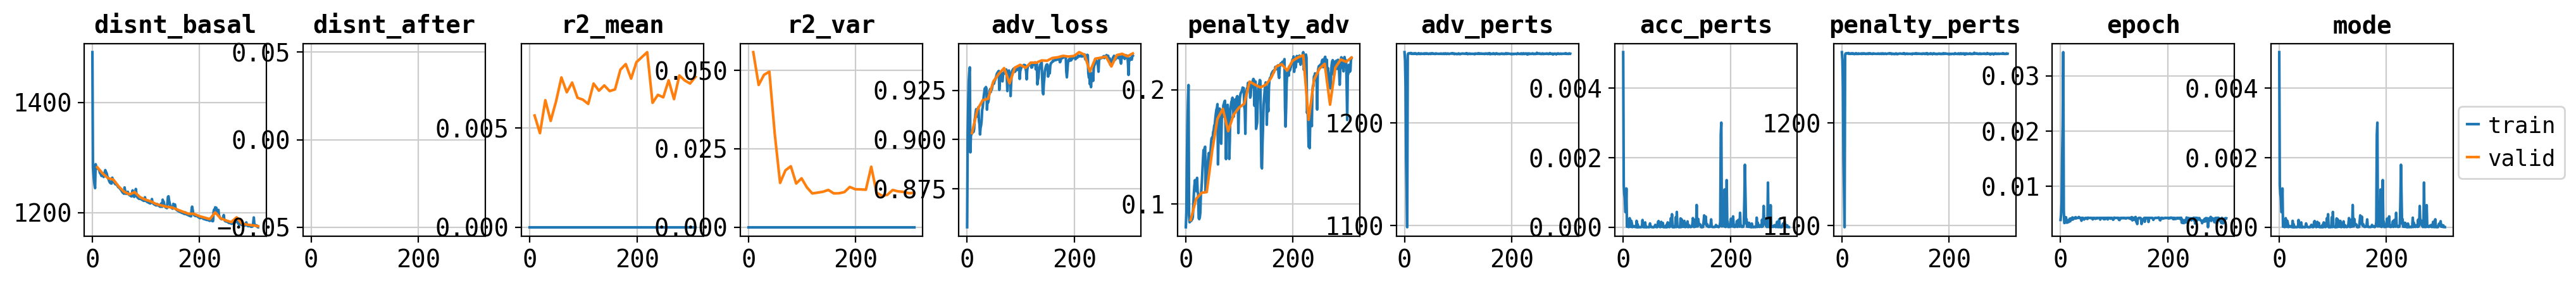

In [15]:
cpa.pl.plot_history(model)

## Restore best model

In case you have already saved your pretrained model, you can restore it using the following code. The `cpa.CPA.load` function accepts the following arguments:
- `dir_path`: path to the directory where the model is saved
- `adata`: anndata object
- `use_gpu`: whether to use GPU or not


In [13]:
# model = cpa.CPA.load(dir_path='/home/mohsen/projects/cpa/lightning_logs/Norman2019/',
#                      adata=adata,
#                      use_gpu=True)

## Latent Space Visualization

latent vectors of all cells can be computed with `get_latent_representation` function. This function produces a python dictionary with the following keys:
- `latent_basal`: latent vectors of all cells in basal state of autoencoder
- `latent_after`: final latent vectors which can be used for decoding
- `latent_corrected`: batch-corrected latents if batch_key was provided

In [14]:
model.predict(adata, batch_size=2048)

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:15<00:00,  3.66it/s]


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
ctrl_adata = adata[adata.obs['condition_ID'] == 'ctrl'].copy()
for condition in tqdm(adata.obs['condition_ID'].unique()):
    if condition != 'ctrl':
        cond_adata = adata[adata.obs['condition_ID'] == condition].copy()

        deg_cat = f'K562_{condition}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cond_adata.layers['counts'].toarray()
        x_pred = cond_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts'].toarray()

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
            
            results['condition'].append(condition)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)
df.head()
    

100%|██████████| 235/235 [03:56<00:00,  1.01s/it]


,condition,n_top_deg,r2_mean_deg,r2_var_deg,r2_mean_lfc_deg,r2_var_lfc_deg
0,UBASH3B+OSR2,10,0.845029,-9.450721,-0.103951,-5.998170
1,UBASH3B+OSR2,20,0.909294,-9.718181,0.268659,-8.177419
2,UBASH3B+OSR2,50,0.953082,-4.703300,0.241855,-10.787834
3,UBASH3B+OSR2,all,0.983968,0.211922,-1.739487,-43.990399
4,FOXL2+HOXB9,10,0.933085,-3.500740,0.690219,-3.909463


In [19]:
df['r2_mean_lfc_deg'].describe()

count    936.000000
mean      -0.304347
std        1.866949
min      -20.490110
25%       -0.290150
50%        0.269398
75%        0.538984
max        0.961299
Name: r2_mean_lfc_deg, dtype: float64

In [16]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)

100%|██████████| 55/55 [00:10<00:00,  5.09it/s]


In [12]:
latent_outputs.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

In [ ]:
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])

In [12]:
cpa_api = cpa.ComPertAPI(adata, model)

In [13]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [14]:
cpa_api.compute_comb_emb(thrh=30)

In [15]:
import pandas as pd

In [16]:
# construct prediction annadata
subset = adata[adata.obs['cell_type'] == 'A549'].copy()
genes_control = subset[subset.obs['condition'] == 'ctrl'].copy()

df = pd.DataFrame({'condition': ['TSC22D1+ctrl'] + ['KLF1+MAP2K6'], 
                   'dose_val': ['1+1'] + ['1+1'], 
                   'cell_type': ['A549']*2})

pred = cpa_api.predict(genes_control.X.toarray(), df)  # normally would put `sample=True` here
pred.obs['cov_drug_dose_name'] = pred.obs['cell_type'].astype(str) + '_' + pred.obs['condition'].astype(str) + '_' + pred.obs['dose_val'].astype(str)
pred.obs['cov_drug_dose_name'] = pred.obs['cov_drug_dose_name'].astype('category')
pred

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


AnnData object with n_obs × n_vars = 17814 × 5000
    obs: 'condition', 'dose_val', 'cell_type', 'uncertainty_cosine', 'uncertainty_euclidean', 'closest_cond_cosine', 'closest_cond_euclidean', 'cov_drug_dose_name'
    layers: 'variance'

In [17]:
adata.obs['cov_drug_dose_name'].unique()

['A549_ctrl_1', 'A549_TSC22D1+ctrl_1+1', 'A549_KLF1+MAP2K6_1+1', 'A549_CEBPE+RUNX1T1_1+1', 'A549_MAML2+ctrl_1+1', ..., 'A549_SNAI1+ctrl_1+1', 'A549_PLK4+STIL_1+1', 'A549_ZBTB10+ELMSAN1_1+1', 'A549_CDKN1C+ctrl_1+1', 'A549_C3orf72+FOXL2_1+1']
Length: 284
Categories (284, object): ['A549_AHR+FEV_1+1', 'A549_AHR+KLF1_1+1', 'A549_AHR+ctrl_1+1', 'A549_ARID1A+ctrl_1+1', ..., 'A549_ctrl+UBASH3B_1+1', 'A549_ctrl+ZBTB1_1+1', 'A549_ctrl+ZBTB25_1+1', 'A549_ctrl_1']

In [18]:
de_dict = adata[adata.obs.split == 'train'].uns['rank_genes_groups_cov']
de_dict = {k: adata.var_names for k, v in de_dict.items()}

In [19]:
pred_adata = pred.concatenate(adata, batch_key='source', batch_categories=['pred', 'true'])

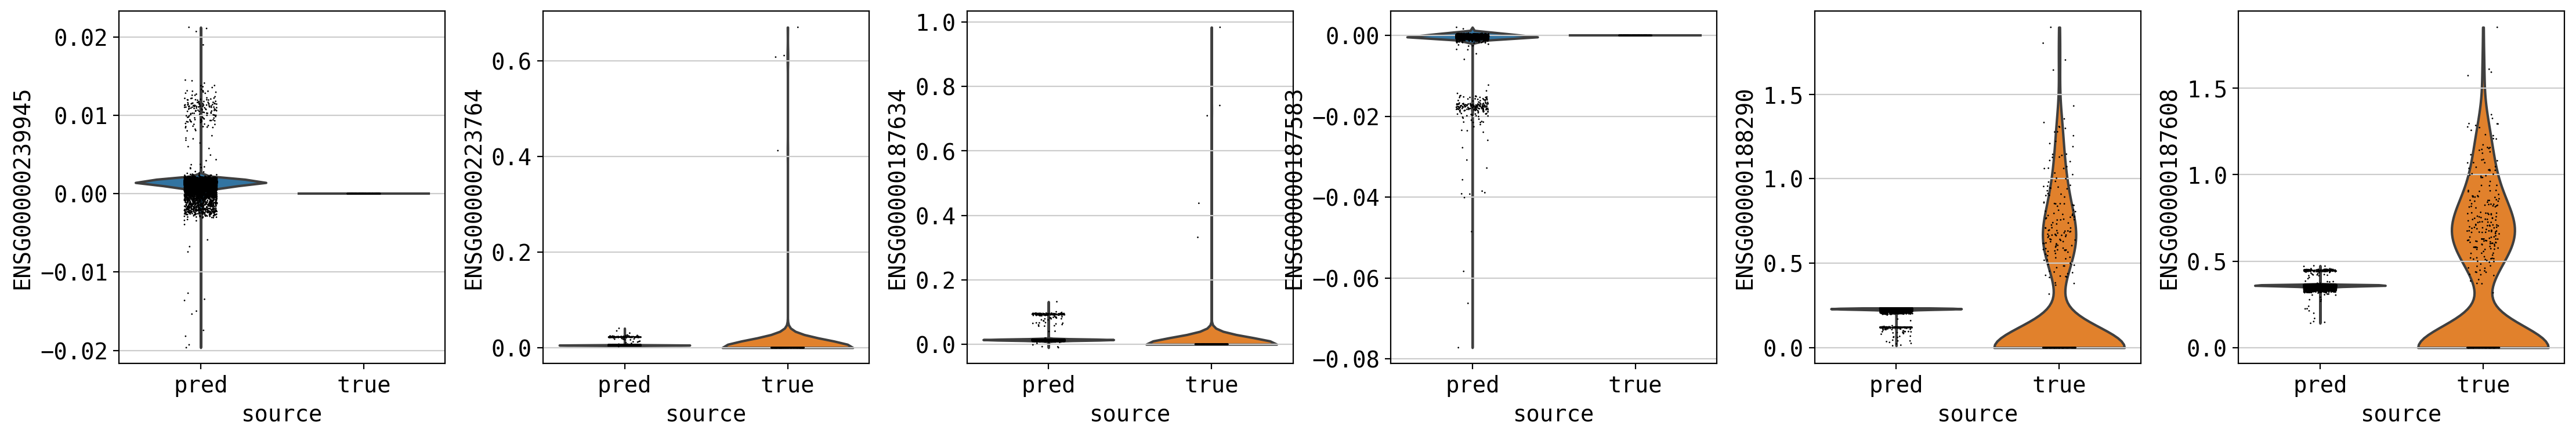

In [20]:
drug_name = 'TSC22D1+ctrl'
sc.pl.violin(
    pred_adata[pred_adata.obs.condition == drug_name],
    keys=de_dict[f'A549_{drug_name}_1+1'][:6],
    groupby='source')